In [421]:
import shap
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.feature_selection import SelectKBest
from scipy.stats import spearmanr
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate,train_test_split
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from feat_imp import *
import warnings

# Feature Importance 

Feature importance algorithms help us in identifying the most important features that are critical in influencing 
the ouput of the ML models. They are primarily used for 3 reasons:-<br>
    1. To understand the data better<br>
    2. Reduce the number of features required<br>
    3. To understand the model better<br>
In this notebook,we primarily look at regression based problems. We look at the diabetes dataset which has 10 features and implement the following methods.<br>
1. Spearman Correlation Rank Coefficient
2. OLS(Lasso)
3. PCA(Feature Compression)



### Spearman Correlation Rank Coefficient


 Spearman's rank correlation coefficient is a nonparametric measure of rank correlation (statistical dependence between the rankings of two variables). 
    It assesses how well the relationship between two variables can be described using a monotonic function. The Spearman correlation between two variables is equal to the Pearson correlation between the rank values of those two variables.<br>
<img src = "https://wikimedia.org/api/rest_v1/media/math/render/svg/ee94267b983c2f16be1d3c61556e264762d5cba9">
In order to calculate the spearman correlation rank, the correlation between the features and the target variable is calculated and sorted in descending order.

In [422]:
X,y = shap.datasets.diabetes()
X = pd.DataFrame(X)
#X.columns = ['feature_{}'.format(x+1) for x in X.columns]
correlations = [spearmanr(X[feature],y) for feature in X.columns]
corr_pvalues = [corr[1] for corr in correlations]
correlations = [corr[0] for corr in correlations]
spearman_df = pd.DataFrame([X.columns,correlations,corr_pvalues],index = ['Feature','SpearManCoeff','pvalue']).T

- The Spearman correlation coefficient, rs, can take values from +1 to -1. 
- A rs of +1 indicates a perfect association of ranks, a rs of zero indicates no association between ranks and a rs of -1 indicates a perfect negative association of ranks. 
- The closer rs is to zero, the weaker the association between the ranks.
- The p values let us know statistically if there is a monotonic relation between the feature and the target variable.

In [423]:
spearman_df

,Feature,SpearManCoeff,pvalue
0,age,0.197822,0.000028
1,sex,0.037401,0.432832
2,bmi,0.561382,0.0
3,bp,0.416241,0.0
4,s1,0.232429,0.000001
5,s2,0.195834,0.000034
6,s3,-0.410022,0.0
7,s4,0.448931,0.0
8,s5,0.589416,0.0
9,s6,0.350792,0.0


As per the above, we can see that feature 2 has a p value of 0.432 and hence, we can conclude that at the 5% level of significance,
that feature 2 is not montonically associated with the target variable.

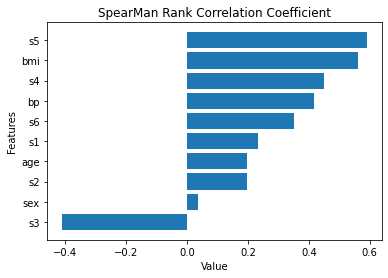

In [424]:
fig,axes = plt.subplots()
axes.barh(spearman_df.sort_values('SpearManCoeff',ascending = True)['Feature'],\
          spearman_df.sort_values('SpearManCoeff',ascending = True)['SpearManCoeff']);
axes.set_title('SpearMan Rank Correlation Coefficient');
axes.set_ylabel('Features');
axes.set_xlabel('Value');

A problem with SpearMan correlation coefficient is that it presumes that the features are not correlated to each other.
If two features are correlated to each other, it would show as having similar rank correlated coefficient.

### Lasso Regression(Feature Selection)

The word "Lasso" stands for Least Absolute Shrinkage and Selection Operator. 
Lasso regression is a regression analysis method that performs both variable selection and regularization. Here it performs
L1 regularization as follows:-<br>
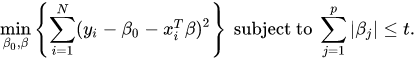<br>
Here t is a Hyperparameter that we are tuning. A lower t would mean that lower features are being selected.<br>
In the sklearn implementation that we are using, the parameter is alpha. Higher the alpha, the more stringent is the feature selection. In the below example, we take $\alpha$ = 0.01 for a start. We should ideally get at the ideal value of $\alpha$.

In [425]:
X_scalar = StandardScaler()
y_scalar = StandardScaler()
model = Lasso(alpha = 0.01)
model.fit(X_scalar.fit_transform(X),y_scalar.fit_transform(y.reshape(-1,1)));
lasso_coeff = model.coef_
lasso_df = pd.DataFrame([X.columns,lasso_coeff],index = ['Feature','LassoCoeff']).T

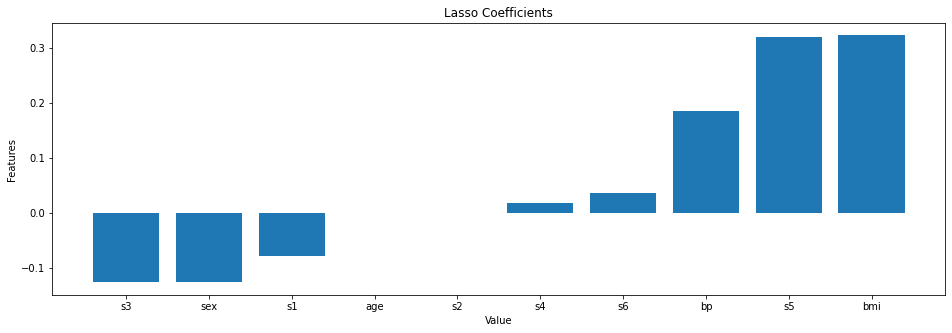

In [426]:
fig,axes = plt.subplots(figsize = (16,5))
axes.bar(lasso_df.sort_values('LassoCoeff',ascending = True)['Feature'],\
          lasso_df.sort_values('LassoCoeff',ascending = True)['LassoCoeff']);
axes.set_title('Lasso Coefficients');
axes.set_ylabel('Features');
axes.set_xlabel('Value');

At alpha = 0.01, we consider feature 1 and feature 6 to be features that are not important. In the Spearman rank correlation
coefficient, it was feature 2. This shows that separate methods have seperate ways of selecting features and they might not arrive at the same conclusion. 

### PCA(NOT Feature selection)



Principal component analysis, or PCA, is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.
However, this does not help in feature selection as when it reduces the number of variables present, this results in
the non-interpretability of the features.

In [427]:
model = PCA(10)
model.fit(X);
#model.explained_variance_ratio

After training the model, if there is a high number of features which are correlated, this would result in a highly right skewed graph with the initial output variables explaining most of the variance.

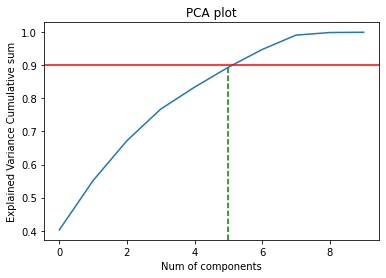

In [428]:
fig,axes = plt.subplots()
axes.plot(model.explained_variance_ratio_.cumsum());
axes.axhline(0.9,color = 'red');
axes.axvline(5,0,0.8,color = 'green',linestyle = '--');
axes.set_ylabel('Explained Variance Cumulative sum');
axes.set_xlabel('Num of components');
axes.set_title('PCA plot');

This means that at num_of_components = 5, the PCA was able to explain ~90% of the variance involved.

### Disadvantages of Rank Correlation Coefficient
What if there are multiple correlation coefficients, then the feature selection should ideally discard the highly correlated features. For this exercise, we add a highly correlated variable and check the results.

In [429]:
X_corr = X.copy()
np.random.seed(42)
X_corr['feature_corr'] = X['bmi'] + np.random.rand(X_corr.shape[0])/10
np.corrcoef(X_corr['feature_corr'],X_corr['bmi'])[1][0]

0.8540891265923947

There is an 85% correlation between the correlated feature and feature 10.

In [430]:
correlations = [spearmanr(X_corr[feature],y) for feature in X_corr.columns]
corr_pvalues = [corr[1] for corr in correlations]
correlations = [corr[0] for corr in correlations]
spearman_df = pd.DataFrame([X_corr.columns,correlations,corr_pvalues],index = ['Feature','SpearManCoeff','pvalue']).T

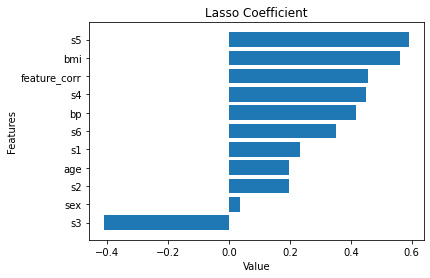

In [431]:
fig,axes = plt.subplots()
axes.barh(spearman_df.sort_values('SpearManCoeff',ascending = True)['Feature'],\
          spearman_df.sort_values('SpearManCoeff',ascending = True)['SpearManCoeff']);
axes.set_title('Lasso Coefficient');
axes.set_ylabel('Features');
axes.set_xlabel('Value');

The correlated feature has a high Rank Coefficient.

In [432]:
X_scalar = StandardScaler()
y_scalar = StandardScaler()
model = Lasso(alpha = 0.01)
model.fit(X_scalar.fit_transform(X_corr),y_scalar.fit_transform(y.reshape(-1,1)));
lasso_coeff = model.coef_
lasso_df = pd.DataFrame([X_corr.columns,lasso_coeff],index = ['Feature','LassoCoeff']).T

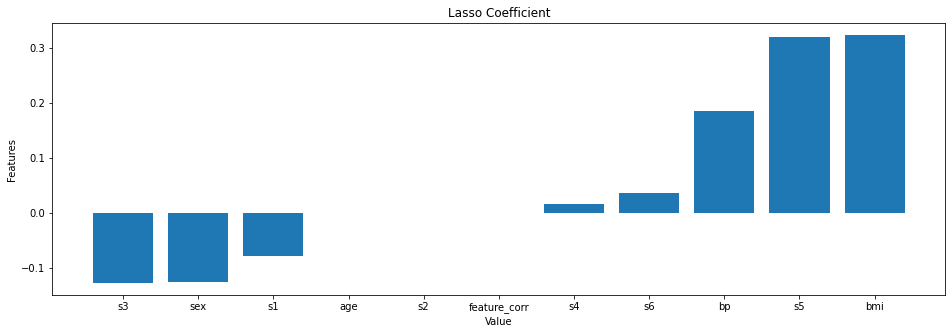

In [433]:
fig,axes = plt.subplots(figsize = (16,5))
axes.bar(lasso_df.sort_values('LassoCoeff',ascending = True)['Feature'],\
          lasso_df.sort_values('LassoCoeff',ascending = True)['LassoCoeff']);
axes.set_title('Lasso Coefficient');
axes.set_ylabel('Features');
axes.set_xlabel('Value');

Feature 10 was selected while feature_correlated was not selected. Since, only 1 of the features need to be selected.We
can suggest that Lasso Regressor is a better feature selection algorithm than Spearman Correlation coefficient when 
correlated variables are involved.

Similarly, PCA should not have any decrease in cumulative explained variance ratio at num_of_components = 5.

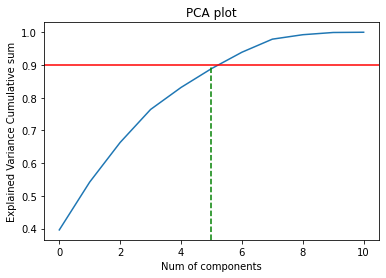

In [434]:
model = PCA(11)
model.fit(X_corr);
fig,axes = plt.subplots()
axes.plot(model.explained_variance_ratio_.cumsum());
axes.axhline(0.9,color = 'red');
axes.axvline(5,0,0.8,color = 'green',linestyle = '--');
axes.set_ylabel('Explained Variance Cumulative sum');
axes.set_xlabel('Num of components');
axes.set_title('PCA plot');

The 90% variance explainability is still at num_of_components = 5.

### Comparing strategies

In [435]:
pca_metrics = [pca_metric(k,X,y,5) for k in range(1,11)]
lasso_alphas = [0.001,0.01,0.02,0.03,0.09,0.1,0.2,0.3,0.4,0.58]
lasso_metrics = [lasso_metric(k,X,y,5) for k in lasso_alphas[::-1]]
spearman_metrics = [spearman_metric(k,X,y,5) for k in range(1,11)]

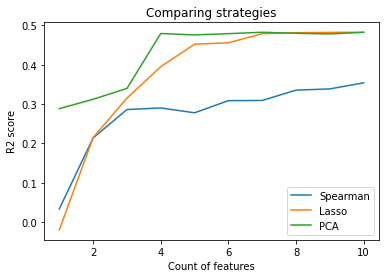

In [436]:
fig,axes = plt.subplots()
count = [x for x in range(1,11)]
axes.plot(count,[x[0] for x in spearman_metrics],label = 'Spearman');
axes.plot(count,[x[0] for x in lasso_metrics],label = 'Lasso');
axes.plot(count,[x[0] for x in pca_metrics],label = 'PCA');
axes.legend();
axes.set_title('Comparing strategies');
axes.set_ylabel('R2 score');
axes.set_xlabel('Count of features');

We can see that PCA performs best wrt minimal features because it takes a combination of features and compresses the information/variance of
features into lower dimensions. However, in terms of removing coefficients, lasso performs well and stabilizes at features = 7.

### SHAP

The arguably important feature importance algorithm is SHAP or SHAPley values.SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. For this exercise, we use a different dataset called corrgroups60 which is a dataset with tight correlations amongst its features. Shapley values are based on the idea that the outcome of each possible combination (or coalition) of players should be considered to determine the importance of a single player. SHAP requires to train a distinct predictive model for each distinct coalition in the power set, meaning $2^F$ models. Of course, these models are completely equivalent to each other for what concerns their hyperparameters and their training data (which is the full dataset). The only thing that changes is the set of features included in the model.
[Ref](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30)

Since, SHAP is a model agnostic approach, we use a simple LinearRegression model to explain the model

In [437]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0)


Rather than use the whole training set to estimate expected values, we summarize with a set of weighted kmeans, each weighted by the number of points they represent. We fit a Linear model and then derive SHAPLEY values from it.

In [438]:
X_train_summary = shap.kmeans(X_train, 10)
lin_regr = LinearRegression()
lin_regr.fit(X_train,y_train);

In [439]:
ex = shap.KernelExplainer(lin_regr.predict, X_train)

X does not have valid feature names, but LinearRegression was fitted with feature names
Using 353 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [440]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = ex.shap_values(X_test)

  0%|          | 0/89 [00:00<?, ?it/s]

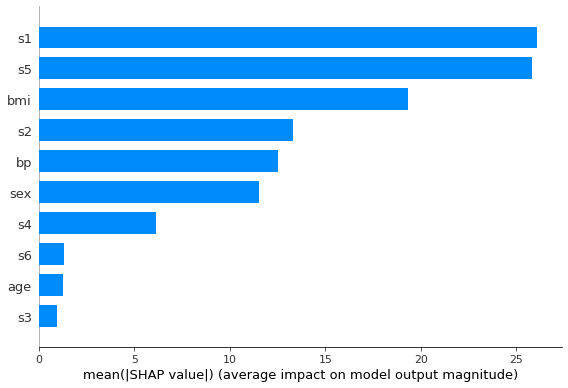

In [441]:
feature_importance = pd.DataFrame((zip(X.columns[np.argsort(np.abs(shap_values).mean(0))],
np.abs(shap_values).mean(0))), columns=["feature", "importance" ]).sort_values(by="importance", ascending=False)
shap.summary_plot(shap_values, X_test,plot_type = 'bar')

As per SHAP, we can see that s6,age and s3 are the least important features while the most important features are s1,s5
and bmi. We can see that this differs slightly from Lasso where s2,age and s4 and s6 are the least important features.

### Automatic Feature Selection Algorithm based on SHAP

We use the similar K most features approach and send it through a CV fold approach. The point where R2 stabilizes should be the ideal feature selection.

In [447]:
def shap_metric(k,X,y,n_splits,features):
    kf = KFold(n_splits=n_splits)
    metric_list = []
    features = features[:k]
    for split in kf.split(X,y):
        X_train = X[features].iloc[split[0]]
        y_train = y[split[0]]
        model = LinearRegression()        
        model.fit(X_train,y_train)
        metric = r2_score(y_test,model.predict(X_test[features]))
        metric_list.append(metric)
    return sum(metric_list)/5

In [444]:
metric_scores = [shap_metric(k,X,y,5,feature_importance['feature'].values) for k in range(1,11)]

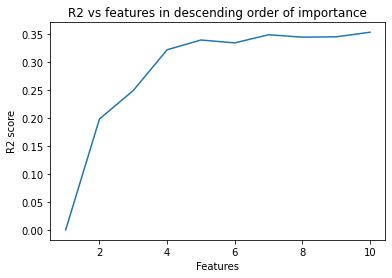

In [448]:
fig,axes = plt.subplots()
axes.plot([x for x in range(1,11)],metric_scores);
axes.set_xlabel('Features');
axes.set_ylabel('R2 score');
axes.set_title('R2 vs features in descending order of importance');

According to SHAP, the most important features are 6 in number i.e. sex,s5,s6,bp,s4 and age.

### Random Forests Feature Importance & Permutation Importance

We have seen that the linear regression models are unable to do a good job at predicting the y variable. Let us try random forests 
and check if they can do better. Random Forests use bagging and are an ensemble method.Hence, the feature importance cannot be explained 
by coefficients such as in Lasso.

In [450]:
from sklearn.ensemble import RandomForestRegressor

In [491]:
model = RandomForestRegressor(max_depth = 100,n_estimators=170 )
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train,y_train);

In [514]:
feature_importance = pd.DataFrame([model.feature_names_in_,model.feature_importances_]).T
feature_importance.columns = ['Feature','Feature Importance values']
feature_importance = feature_importance.sort_values('Feature Importance values',ascending = False)

The feature importance are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

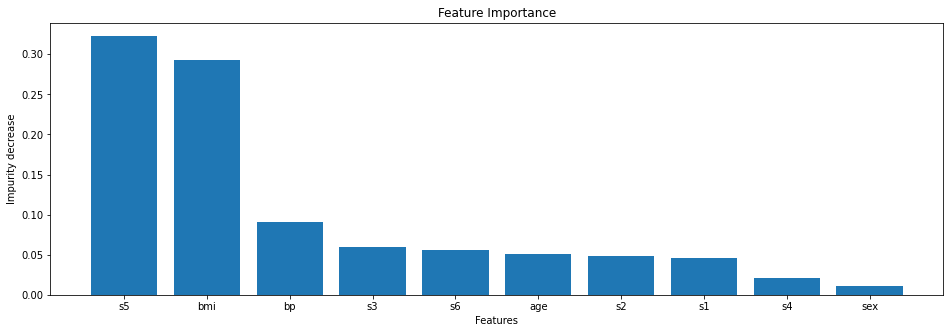

In [517]:
fig,axes = plt.subplots(figsize = (16,5))
axes.bar(feature_importance['Feature'],\
          feature_importance['Feature Importance values']);
axes.set_title('Feature Importance');
axes.set_ylabel('Impurity decrease');
axes.set_xlabel('Features');

In [518]:
from sklearn.inspection import permutation_importance

In [519]:
r = permutation_importance(model, X_test, y_test,
                            n_repeats=30,
                           random_state=0)

In [536]:
for i in r.importances_mean.argsort()[::-1]:
            print(f"{model.feature_names_in_[i]:<8}"
                  f"{r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")

s5      0.188 +/- 0.089
bmi     0.114 +/- 0.067
bp      0.042 +/- 0.041
age     0.006 +/- 0.012
sex     0.002 +/- 0.008
s2      0.002 +/- 0.017
s6      0.001 +/- 0.013
s3      0.001 +/- 0.022
s4      -0.006 +/- 0.007
s1      -0.010 +/- 0.013


As per permutation importance and random forest importance, we are getting the same values i.e. s5,bmi and bp.

If we observe, while the majority of features remain the same for random forest importance, we can see that the feature 
importance for Lasso/random forests are slightly different.

### Random Forests Feature Importance as per TreeSHAP

In [537]:
shap_values = shap.TreeExplainer(model).shap_values(X)

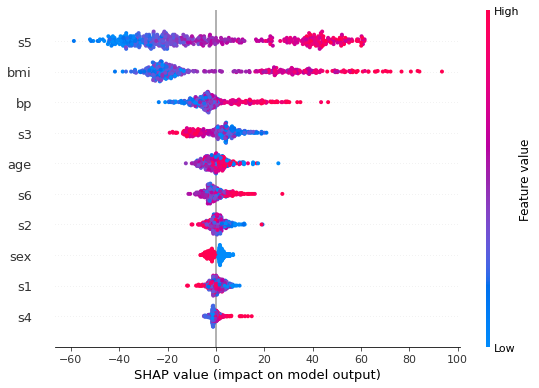

In [539]:
shap.summary_plot(shap_values, X)

Even as per SHAP, we are able to get s5 and bmi as the most important features as per SHAP.

### Conclusion

As per this exercise, we can see that different feature importance algorithms can result in varying output even when done
on the same dataset with the same model. Feature importance can also change as the algorithm is changing just as in 
RF vs Regression.

**This report was done as an assignment for HW3 of the Data Structures and Algorithms course(MSDS 689)**